In [21]:
import matplotlib.pyplot as plt
import random
import networkx as nx

In [47]:
# social dynamics simulation
class social_dynamics():
    # initiate the parameters network size, alpha, beta and gamma
    def __init__(self, network_size = 50, alpha = 0.03, beta = 0.3, gamma = 4):
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    # create the initial graph    
    def initialize(self):
        # create a scale-free barabasi albert graph
        self.graph = nx.barabasi_albert_graph(self.network_size, 5)
        # assign weight to edges, 0.5 as default
        for edge in self.graph.edges:
            self.graph.edges[edge]["weight"] = 0.5
        # assign attributes to nodes, either 0 or 1 randomly for opinion and 0 for persuasiveness
        for node in self.graph.nodes:
            self.graph.nodes[node]["opinion"] = random.randint(0, 1)
            self.graph.nodes[node]["persuasiveness"] = 0
        # randomly pick 1% of the population to make them charismatic, with persuasiveness value as 1
        for i in range(int(self.network_size*0.01)):
            k = 0
            while k < 1:
                if self.graph.nodes[random.choice(list(self.graph.nodes))]["persuasiveness"] == 0:
                    self.graph.nodes[random.choice(list(self.graph.nodes))]["persuasiveness"] = 1
                    k = k + 1
        # initial visual layout
        self.layout = nx.spring_layout(self.graph)  
        self.step = 0
        
    # visualize the network    
    def observe(self):
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]["opinion"] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]["weight"] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title("Step: " + str(self.step))
        
    # update the network
    def update(self):
        # random strangers get connected to each other
        if random.random() < 0.01:
            k = 0
            while k < 1:
                # get 2 random nodes
                new_edge = random.sample(list(self.graph.nodes), 2)
                # check if they are connected
                if new_edge not in list(self.graph.edges):
                    # connect them if they are not connected
                    self.graph.add_edge(new_edge[0], new_edge[1], weight = 0.5)
                    k = k + 1
                    
        # unconnected people with a mutual friend get connected            
        elif random.random() < 0.02:
            # get a random node
            node = random.choice(list(self.graph.nodes))
            # if the node has at least a neighbor
            if len(list(self.graph.neighbors(node))) > 0:
                # get all the nodes that are not its neighbors
                not_neighbor = [n for n in list(self.graph.nodes) if n not in list(self.graph.neighbors(node)) and n != node]
                far_neighbor = []
                if len(not_neighbor) > 0:
                    for each in not_neighbor:
                        for neigh in list(self.graph.neighbors(node)):
                            # if the non-neighbors are neighbors to the node's neighbors, add to the far acquaintances list
                            if (each, neigh) in list(self.graph.edges) or (neigh, each) in list(self.graph.edges):
                                far_neighbor.append(each)
                                break
                    if len(far_neighbor) > 0:
                        # connect the node with one of its far acquaintances randomly if there is any
                        self.graph.add_edge(node, random.choice(far_neighbor), weight = 0.5)
                        # otherwise, connect it with any of the strangers
                    else:
                        self.graph.add_edge(node, random.choice(not_neighbor), weight = 0.5)
                    
            # if the node does not have any neighbor    
            else:
                a = list(self.graph.nodes)
                a.remove(node)
                first_neighbor = random.choice(a)
                # connect it with a random node in the network
                self.graph.add_edge(node, first_neighbor, weight = 0.5)
                
        # if connected people talk to each other        
        else:
            # get a random pair of connected nodes
            edge = random.choice(list(self.graph.edges))
            # get the weight, opinions and persuasiveness
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            persuasiveness = [self.graph.nodes[n]['persuasiveness'] for n in edge]
            # if 2 are equally persuasive, apply the standard formula of opinion change
            if persuasiveness[0] == persuasiveness[1]:
                for i in [0, 1]:
                    self.graph.nodes[edge[i]]['opinion'] = (
                        opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            # if they are not equally persuasive    
            else:
                norm = persuasiveness.index(0)
                char = persuasiveness.index(1)
                # the normal one changes their opinion to the charismatic one's, the charismatic one changes their opinion according to the standard rule
                self.graph.nodes[edge[norm]]['opinion'] = self.graph.nodes[edge[char]]['opinion']
                self.graph.nodes[edge[char]]['opinion'] = (opinions[char] + self.alpha * weight * (opinions[norm] - opinions[char]))
                
            # change in strength of relationship
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            
            # the relationship is broken if weight falls under 0.05
            if self.graph.edges[edge]["weight"] < 0.05:
                self.graph.remove_edge(*edge)
                    
        self.step += 1

In [50]:
# simulate the network
def main_sim(a, b, g):
    sim = social_dynamics(alpha = a, beta= b, gamma = g)
    sim.initialize()
    plt.figure()
    sim.observe()

    # display every 2000 steps
    for i in range(10):
        for i in range(2000):
            sim.update()
        plt.figure()
        sim.observe()

In [51]:
from matplotlib import pyplot
import itertools
import scipy


def vector_plot(alpha, beta, gamma):
    cmap = pyplot.cm.viridis  # good for color blindness

    # Traces of how opinion and weight change over time
    for opinion, weight in [
        [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
        [0.85, 0.95], [0.95, 0.95], [1, 0.5], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
        [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
    ]:
        ow = [[opinion, 0.0, weight]]
        for i in range(100):
            delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
        pyplot.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    pyplot.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    pyplot.xlabel('opinion difference')
    pyplot.ylabel('weight')
    pyplot.plot([0, 1], [0.05, 0.05], 'k--')
    pyplot.axis('square')
    pyplot.show()


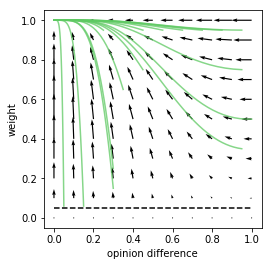

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


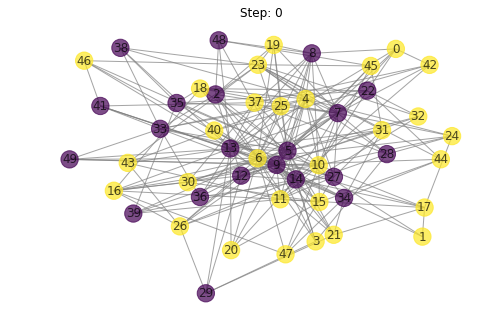

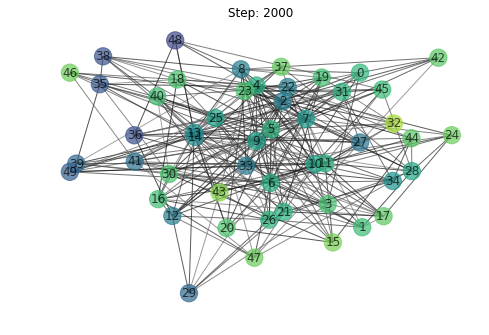

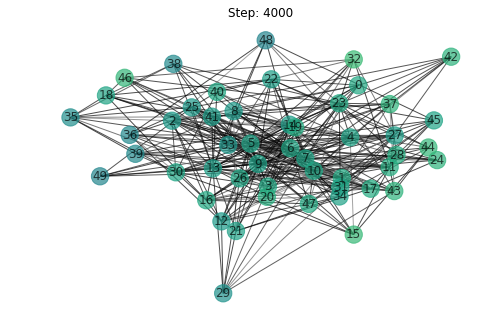

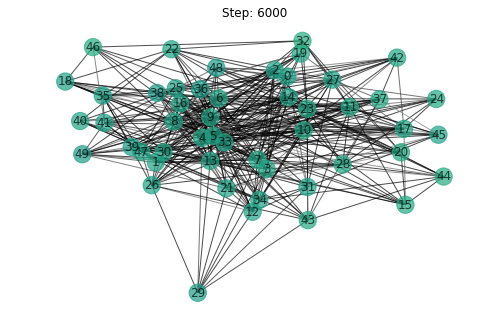

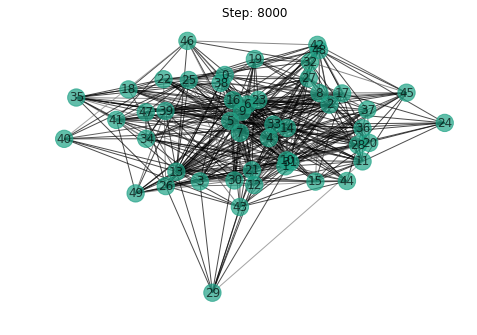

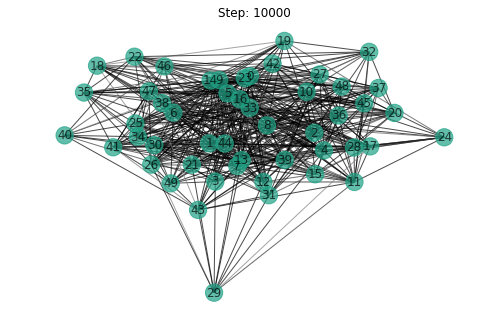

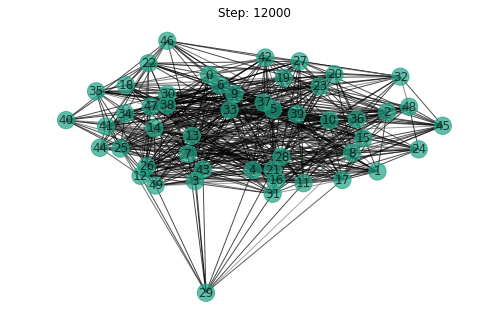

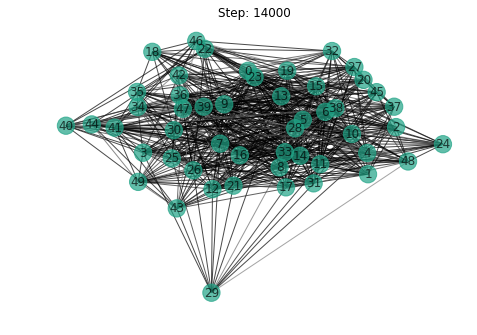

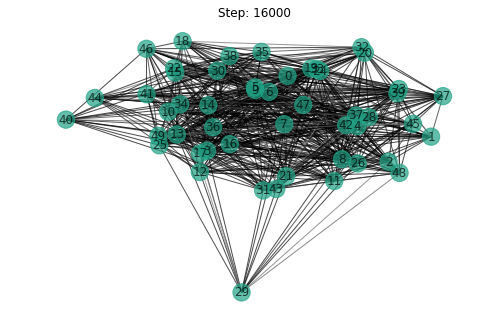

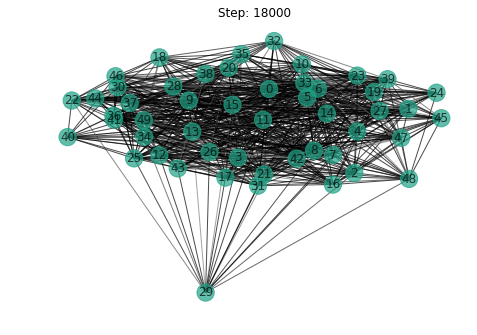

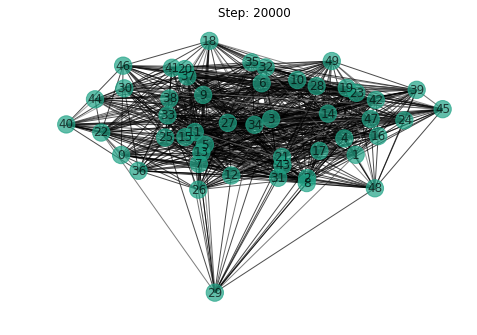

In [52]:
vector_plot(0.03, 0.3, 1)
main_sim(0.03, 0.3, 1)

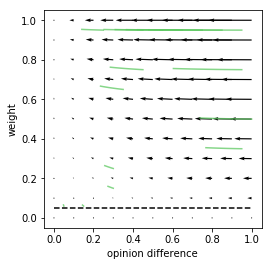

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


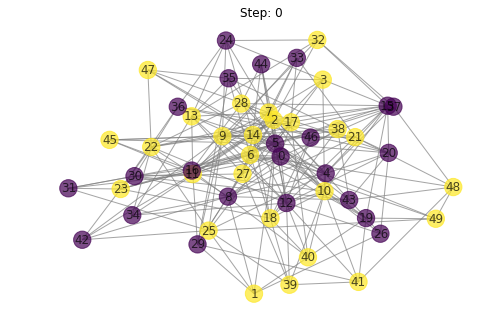

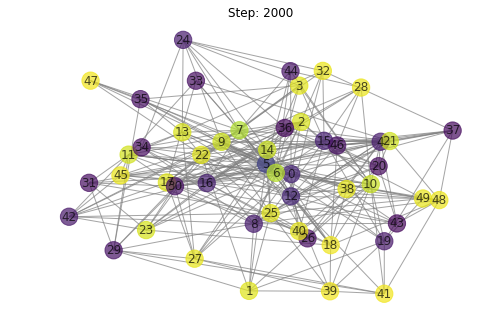

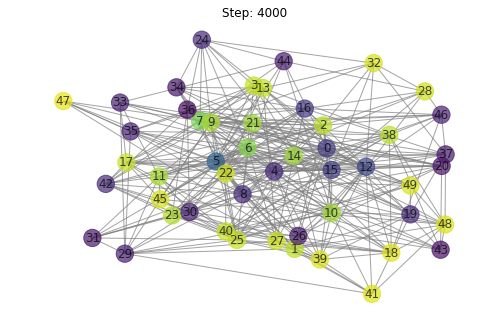

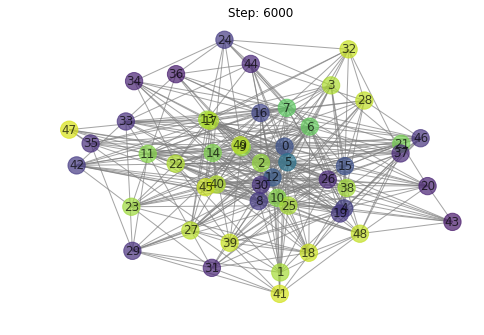

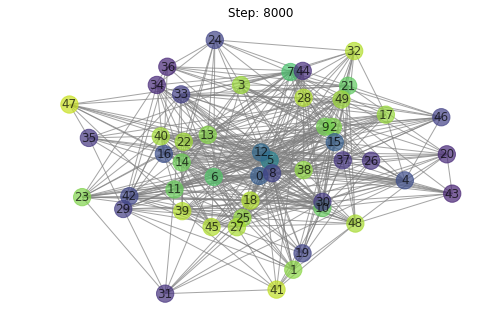

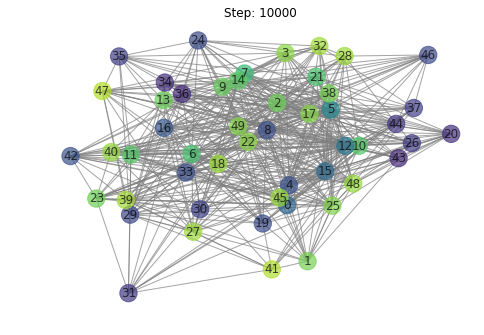

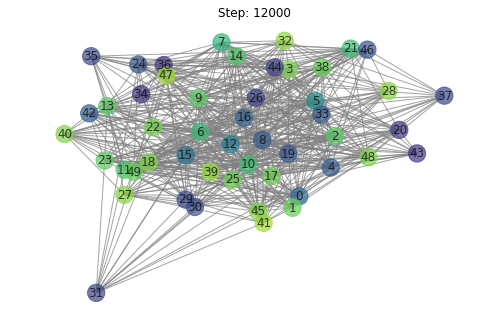

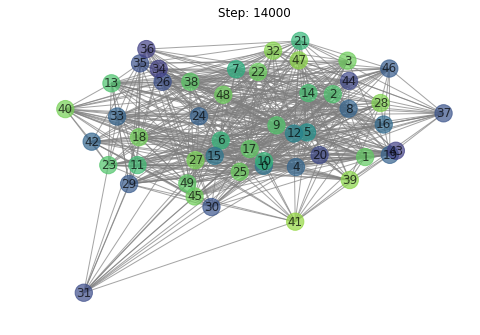

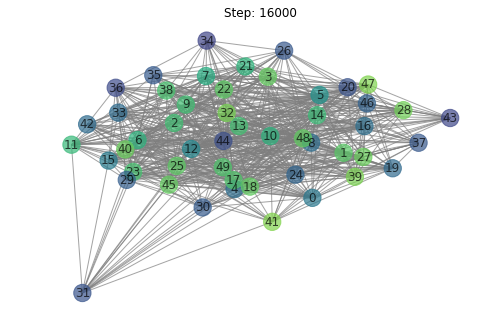

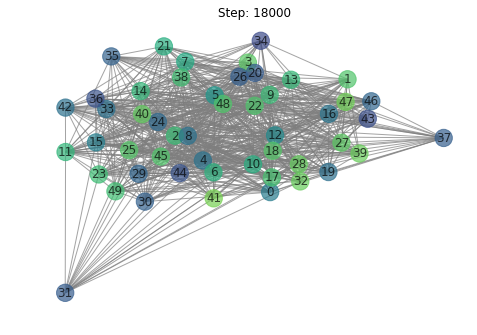

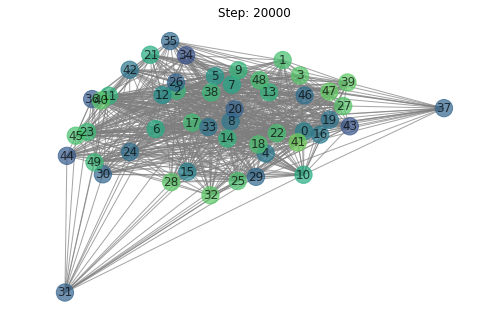

In [54]:
vector_plot(0.003, 0.001, 0.9)
main_sim(0.003, 0.001, 0.9)

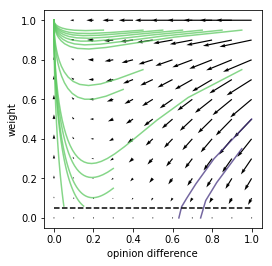

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


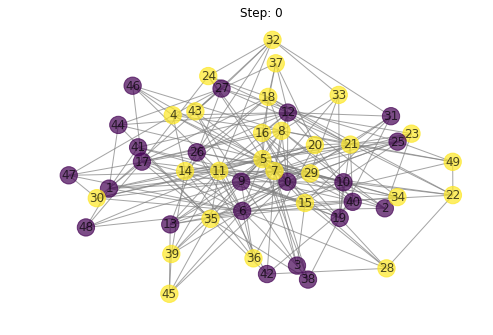

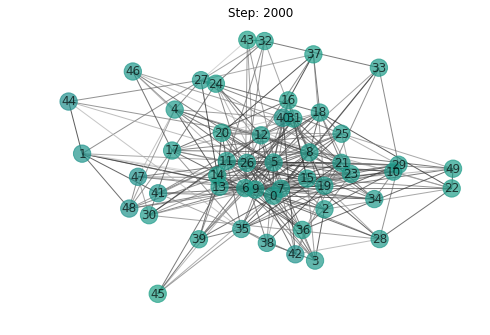

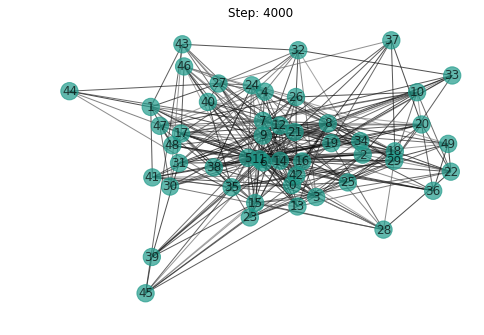

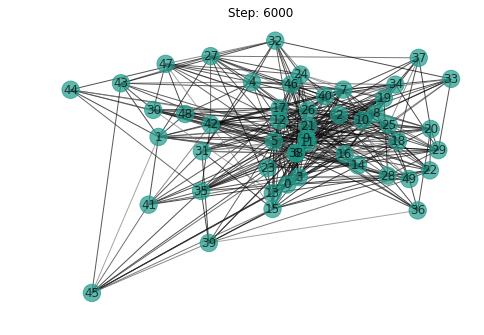

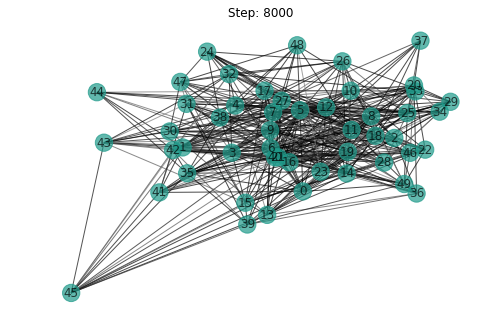

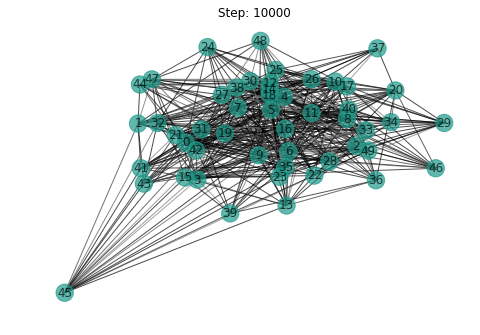

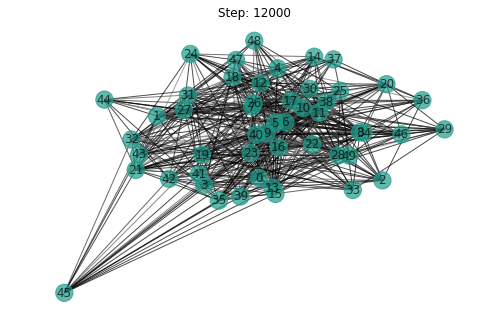

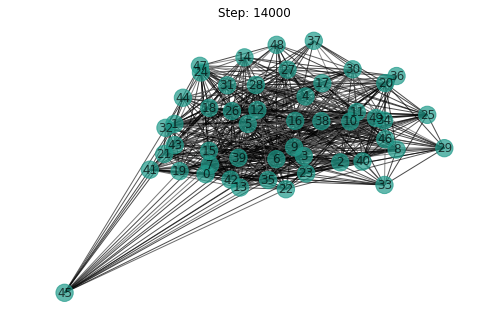

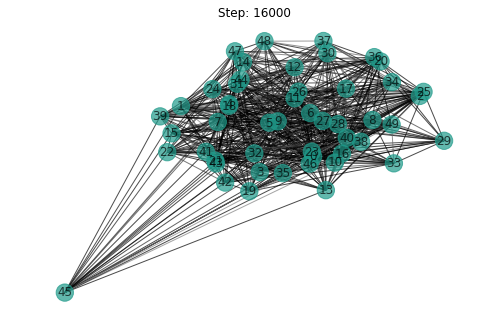

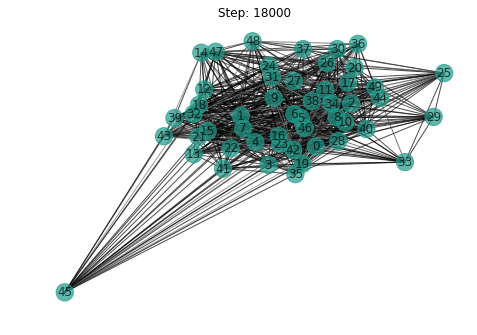

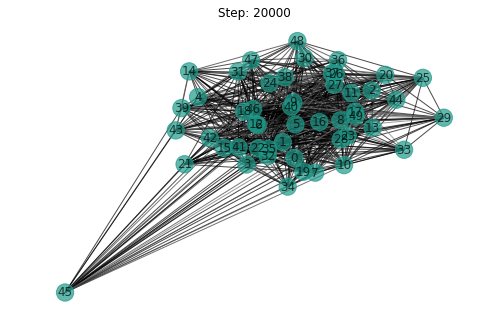

In [55]:
vector_plot(0.19, 0.2, 5)
main_sim(0.19, 0.2, 5)

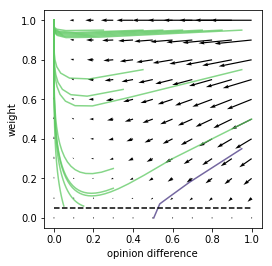

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


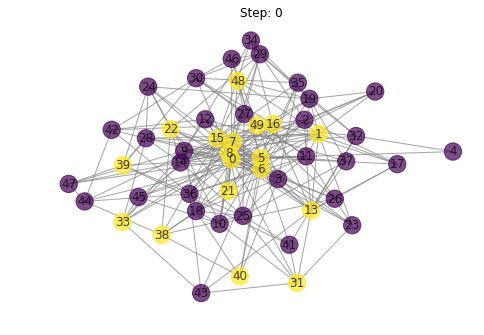

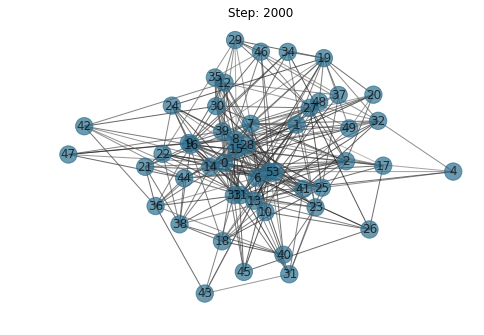

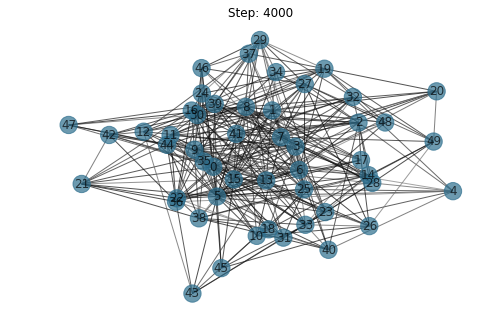

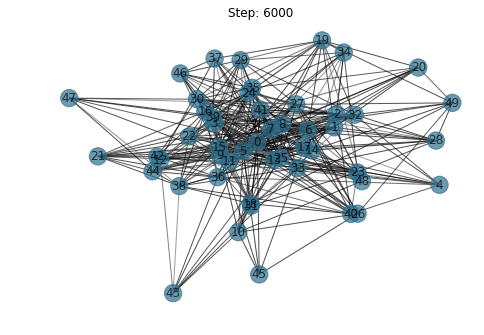

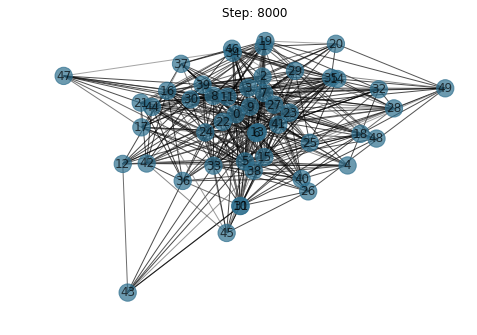

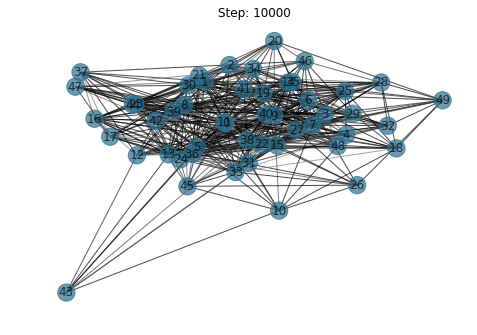

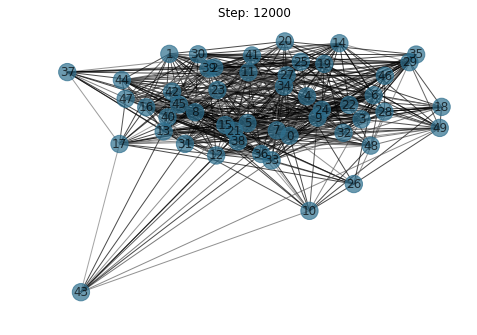

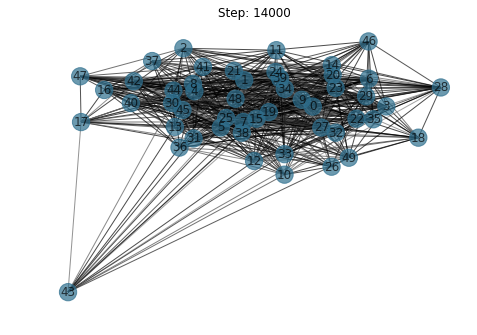

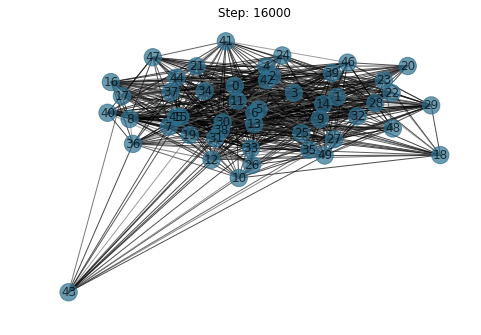

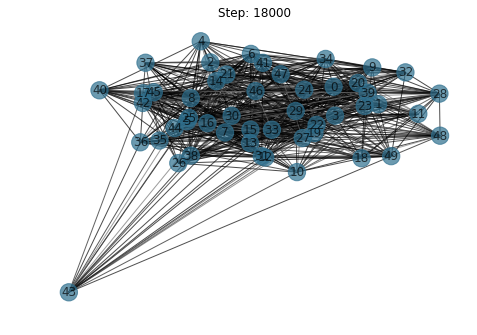

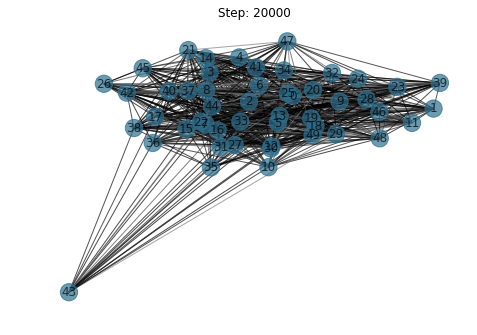

In [56]:
vector_plot(0.4, 0.2, 5)
main_sim(0.4, 0.2, 5)

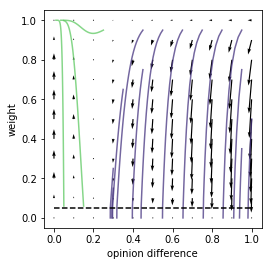

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


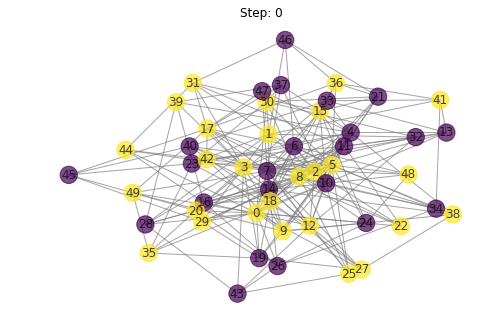

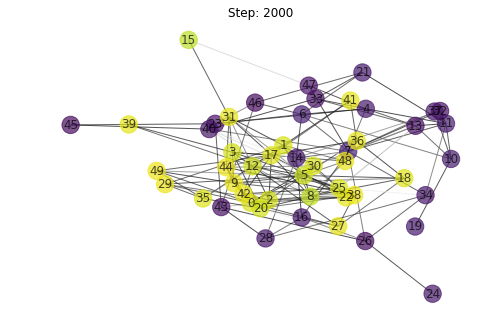

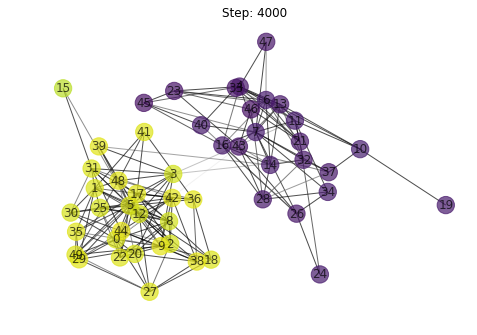

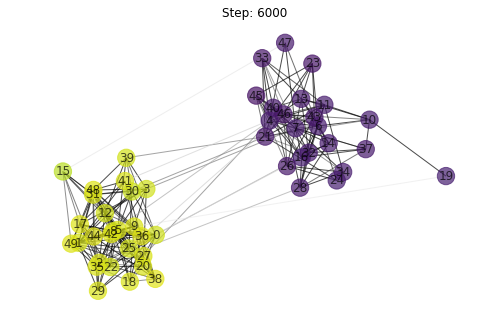

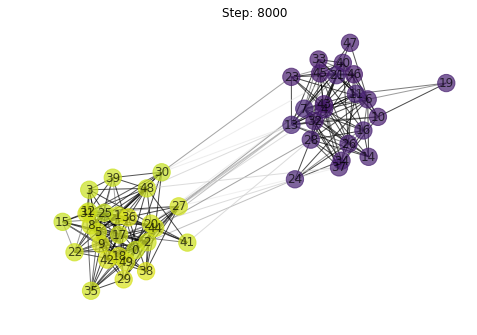

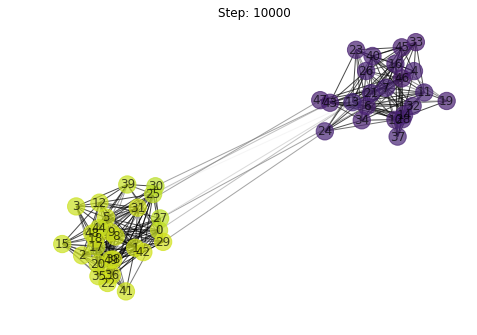

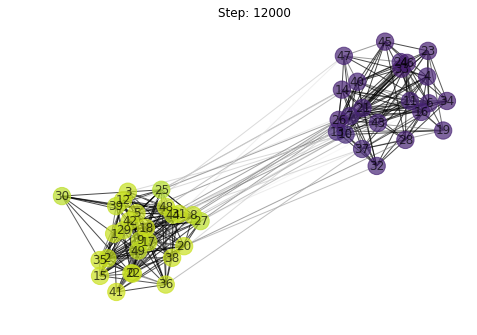

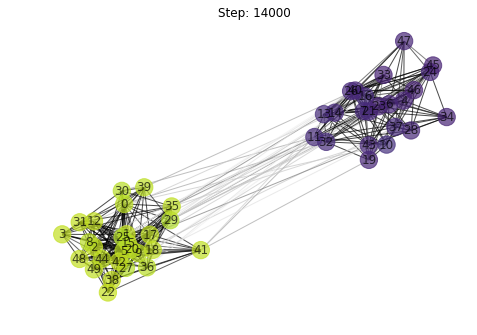

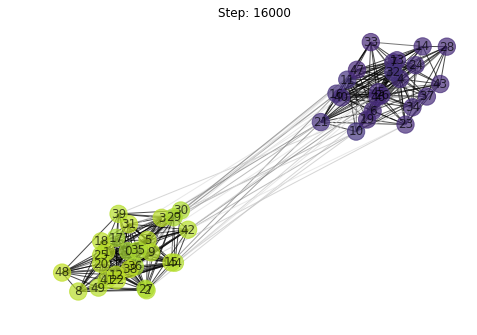

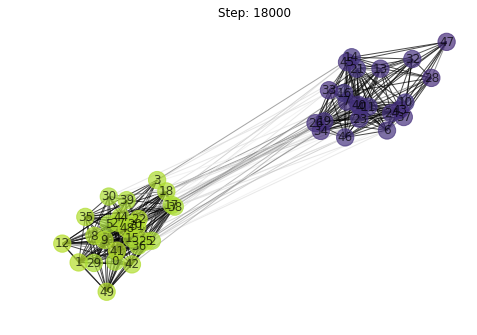

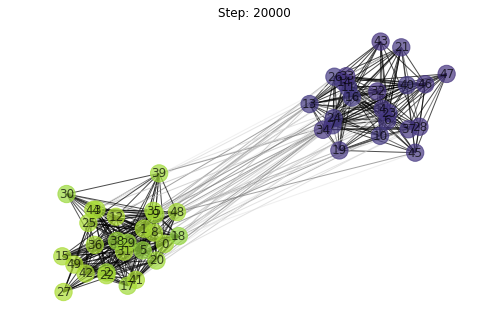

In [57]:
vector_plot(0.01, 0.2, 5)
main_sim(0.01, 0.2, 5)